In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_curve,roc_curve,roc_auc_score

# We split the data into training, testing and validation sets

In [2]:
df = pd.read_csv("cleanedv1.csv")
df = df.dropna()
df["is_not_A"] = df["score"] > 14
df["is_not_A"] = df["is_not_A"].astype(int)
df_cleaned = df[["inspection_count","std_yelp_review_count","std_chain_size","yelp_price","overnight","cuisine_description","is_not_A"]]
df_cleaned = pd.get_dummies(df_cleaned)
train, test = train_test_split(df_cleaned, test_size=0.2, random_state=1)
train, validation = train_test_split(train, test_size=0.2, random_state=1)
train_x = train.drop(columns=["is_not_A"])
test_x = test.drop(columns=["is_not_A"])
validation_x = validation.drop(columns=["is_not_A"])


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# We start with a logistic regression but only get limited results

In [3]:
regr = linear_model.LogisticRegression()
regr.fit(train_x, train["is_not_A"])
predicted_test_y = regr.predict(test_x)

In [4]:
print(classification_report(test["is_not_A"], predicted_test_y))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94      1191
          1       0.40      0.06      0.10       140

avg / total       0.85      0.89      0.85      1331



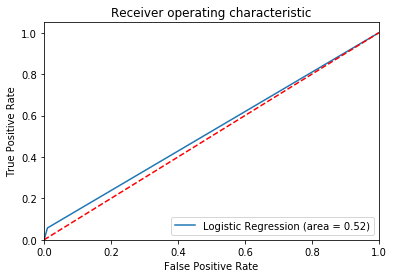

In [5]:
logit_roc_auc = roc_auc_score(test["is_not_A"], predicted_test_y)
fpr, tpr, thresholds = roc_curve(test["is_not_A"], predicted_test_y)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('log_ROC')
plt.show()

# A random forest gives us much better results although it is not interpretable

In [6]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
train.columns
rf.fit(train_x, train["is_not_A"]);

AUC is: 0.745627923713566


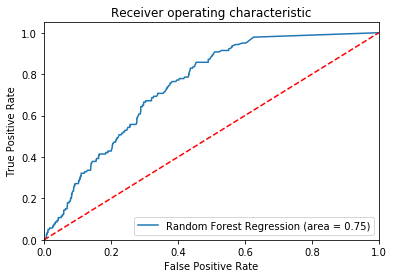

In [7]:
predicted_test_y = rf.predict(test_x)
rf_roc_auc = roc_auc_score(test["is_not_A"], predicted_test_y)
print("AUC is:",rf_roc_auc)
fpr, tpr, thresholds = roc_curve(test["is_not_A"], predicted_test_y)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_test_ROC')
plt.show()

AUC is: 0.7603437106037261


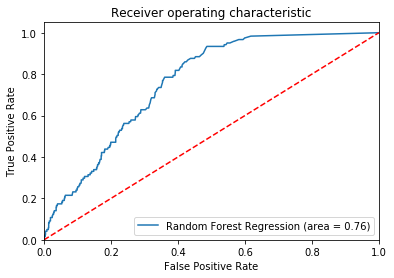

In [8]:
predicted_validation_y = rf.predict(validation_x)
rf_roc_auc = roc_auc_score(validation["is_not_A"], predicted_validation_y)
print("AUC is:",rf_roc_auc)
fpr, tpr, thresholds = roc_curve(validation["is_not_A"], predicted_validation_y)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_validation_ROC')
plt.show()

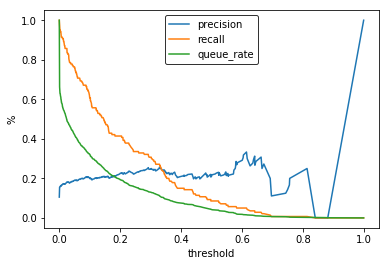

In [9]:
precision, recall, thresholds = precision_recall_curve(test["is_not_A"], predicted_test_y) 
thresholds = np.append(thresholds, 1) 
queue_rate = [] 
for threshold in thresholds: 
    queue_rate.append((predicted_test_y >= threshold).mean()) 
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')
plt.savefig("precision-recall")

In [10]:
threshold = 0.8
new_predicted_test_y = predicted_test_y
new_predicted_test_y = np.where(predicted_test_y>threshold, 1, new_predicted_test_y)
new_predicted_test_y = np.where(predicted_test_y<=threshold, 0, new_predicted_test_y)
print(confusion_matrix(test["is_not_A"], new_predicted_test_y,labels= [0,1]))
print(classification_report(test["is_not_A"], new_predicted_test_y))

[[1188    3]
 [ 139    1]]
             precision    recall  f1-score   support

          0       0.90      1.00      0.94      1191
          1       0.25      0.01      0.01       140

avg / total       0.83      0.89      0.85      1331



In [11]:
df = pd.DataFrame({"thresholds":thresholds,"precision":precision,"recall":recall})

In [12]:
#df[df["thresholds"]>0]